#ЛР №7

Основные понятия ООП. Наследование. Полиморфизм.

#Основное задание




Написать базовый класс BaseProcessing, который предоствляет интерфейс для обработки данных (сигналы и изображения).

В классе BaseProcessing реализовать следующие абстрактные методы:

**Интерфейс BaseProcessing**

* `_filtering()` — осуществляет фильтрацию (абстрактный метод).
* `visualize()` — визуализирует сигнал/изображение (абстрактный метод).
* `get_shape()` — возвращает размерность (абстрактный метод).
* `feature_extraction()` — возвращает вектор признаков (абстрактный метод).


Класс SignalProcessing наследует BaseProcessing и переопределяет его методы

**Интерфейс SignalProcessing** (код для реализации отдельных методов ниже)

* _конструктор_ — принимает на вход путь к файлу и создает соответствующие поля
* `_filtering(signal)` — осуществляет фильтрацию сигнала (возвращает отфильтрованный сигнал).
* `visualize()` — визуализирует сигнал.
* `get_shape()` — возвращает длину сигнала.
* `_signal_find_peaks(signal, find_peaks_parametres)` — находит точки максимума сигнала и возвращает их в виде списка.
* `_calculate_RR_intervals()` — производит расчет длительности RR интервалов (попарных расстояний между пиками) и возвращает длины RR интервалов в виде списка.
В этом методе вызываются методы _filtering и _signal_find_peak.
* `feature_extraction()` — возвращает статистические характеристики RR интервалов на записи ECG - среднее, std, min, max (в виде списка - вектор признаков). В этом методе вызывается метод _calculate_RR_intervals.

Класс ImageProcessing наследует BaseProcessing и переопределяет его методы

**Интерфейс ImageProcessing** (код для реализации отдельных методов из предыдущей лабораторной)

* _конструктор_ — принимает на вход путь к файлу и создает соответствующие поля
* `_filtering(image)` — применяет фильтр Гаусса к изображению (возвращает отфильтрованное изображение).
* `visualize()` — визуализирует изображение.
* `get_shape()` — возвращает размерность изображения.
* `_create_gabor_filter(parameters)` — создает и возвращает фильтр Габора с заданными параметрами.
* `feature_extraction()` — применяет _filtering() к изображению, считает признаки с _create_gabor_filter(parameters)и возвращает вектор признаков: среднее и дисперсию по изображению.

*можно добавить свои методы


Изображение и синал находятся в папке

In [2]:
!pip install wfdb heartpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.4 MB/s eta 0:00:00


In [32]:
#Необходимые модули и функции
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi
import cv2 as cv
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import wfdb
import heartpy as hp
from scipy.signal import find_peaks
from abc import ABC, abstractmethod

<ipython-input-32-c18f831e3a41>:6: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


In [33]:
class BaseProcessing(ABC):
    @abstractmethod
    def _filtering(self):
        pass

    @abstractmethod
    def visualize(self):
        pass

    @abstractmethod
    def get_shape(self):
        pass

    @abstractmethod
    def feature_extraction(self):
        pass

In [34]:
class SignalProcessing(BaseProcessing):
    def __init__(self, file_path):
        self.file_path = file_path
        self.signal = pd.read_csv(file_path)['MLII'].values

    def _filtering(self, signal):
        return hp.filter_signal(signal, cutoff=[0.75, 3.5], sample_rate=100, order=3, filtertype='bandpass')

    def visualize(self):
        plt.plot(self.signal)
        plt.show()

    def get_shape(self):
        return self.signal.shape

    def feature_extraction(self):
        rr_intervals = self._calculate_RR_intervals()
        return [np.mean(rr_intervals), np.std(rr_intervals), np.min(rr_intervals), np.max(rr_intervals)]

    def _signal_find_peaks(self, signal, find_peaks_parameters):
        peaks, _ = find_peaks(signal, **find_peaks_parameters)
        return peaks

    def _calculate_RR_intervals(self):
        filtered_signal = self._filtering(self.signal)
        peaks = self._signal_find_peaks(filtered_signal, {'height': 20})
        rr_intervals = np.diff(peaks)
        return rr_intervals

In [35]:
class ImageProcessing(BaseProcessing):
    def __init__(self, file_path):
        self.file_path = file_path
        self.image = cv.imread(file_path, cv.IMREAD_GRAYSCALE)

    def _filtering(self, image):
        return gaussian_filter(image, sigma=0.5)

    def visualize(self):
        plt.imshow(self.image, cmap='gray')
        plt.show()

    def get_shape(self):
        return self.image.shape

    def _create_gabor_filter(self, parameters):
        frequency, theta, sigma = parameters['frequency'], parameters['theta'], parameters['sigma']
        return np.real(gabor_kernel(frequency, theta=theta, sigma_x=sigma, sigma_y=sigma))

    def feature_extraction(self):
        filtered_image = self._filtering(self.image)
        gabor_filter = self._create_gabor_filter({'frequency': 0.25, 'theta': np.pi, 'sigma': 1})
        conv = ndi.convolve(filtered_image, gabor_filter, mode='wrap')
        return [conv.mean(), conv.var()]

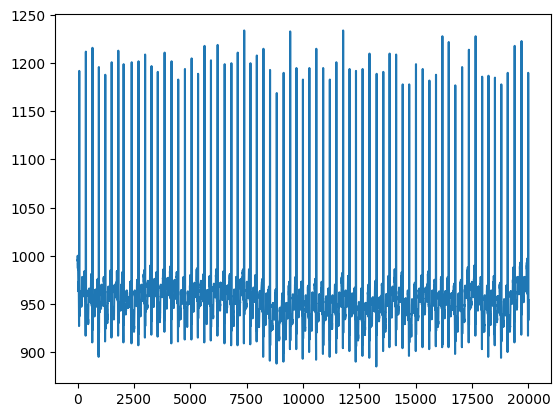

Размерность сигнала: (20000,)


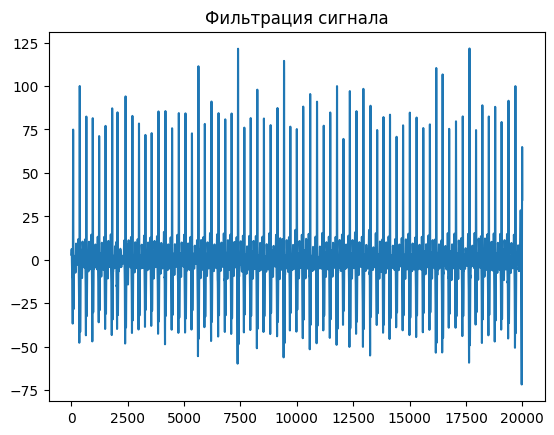

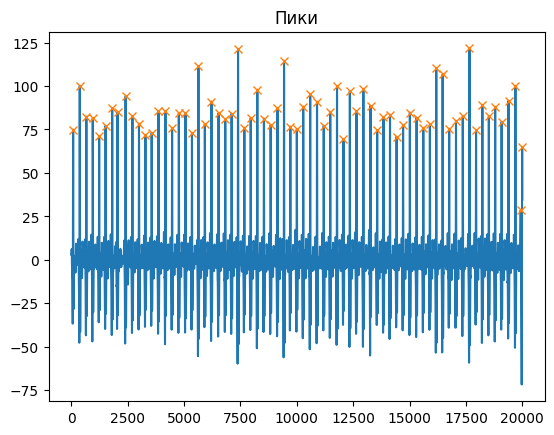

RR интервалы: [293 293 284 284 284 294 236 358 303 292 285 277 303 308 295 299 295 287
 287 284 296 313 297 282 285 279 283 293 293 298 304 290 279 288 284 309
 303 298 288 301 285 284 295 305 317 295 280 289 292 288 300 299 297 293
 283 282 290 303 300 299 290 280 287 282 285 307 305 233  66]
Вектор признаков: [288.6231884057971, 31.077323597890175, 66, 358]


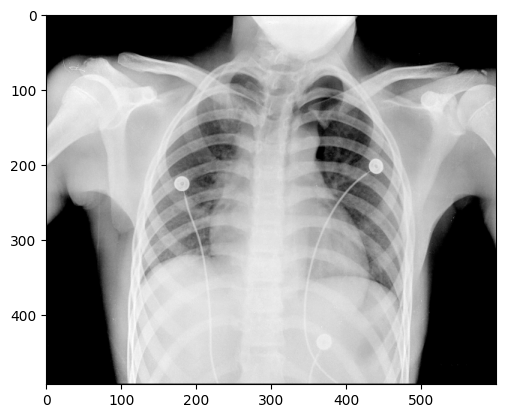

Размерность изображения: (493, 600)


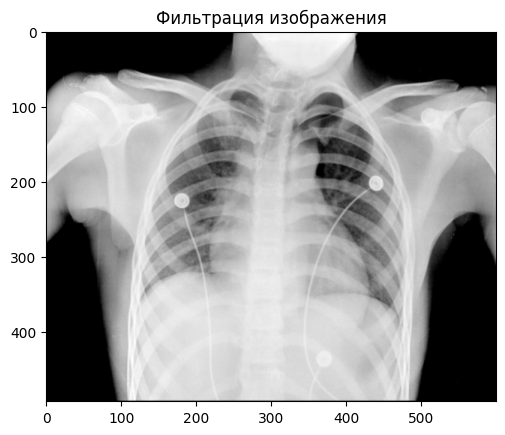

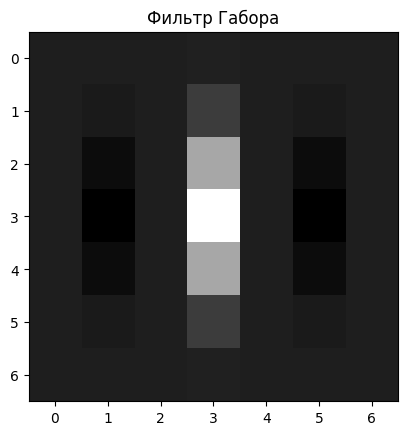

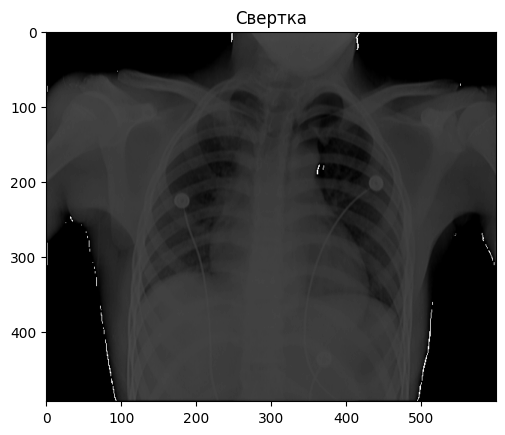

Вектор признаков: [41.113566599053414, 670.1179849805205]


In [38]:
signal_processor = SignalProcessing('ecg.csv')
signal_processor.visualize()
print("Размерность сигнала:", signal_processor.get_shape())

filtered_signal = signal_processor._filtering(signal_processor.signal)
plt.plot(filtered_signal)
plt.title("Фильтрация сигнала")
plt.show()

peaks = signal_processor._signal_find_peaks(filtered_signal, {'height': 20})
plt.plot(filtered_signal)
plt.plot(peaks, filtered_signal[peaks], "x")
plt.title("Пики")
plt.show()

rr_intervals = signal_processor._calculate_RR_intervals()
print("RR интервалы:", rr_intervals)

signal_features = signal_processor.feature_extraction()
print("Вектор признаков:", signal_features)

image_processor = ImageProcessing('chest-xray.tif')
image_processor.visualize()
print("Размерность изображения:", image_processor.get_shape())

filtered_image = image_processor._filtering(image_processor.image)
plt.imshow(filtered_image, cmap='gray')
plt.title("Фильтрация изображения")
plt.show()

gabor_filter = image_processor._create_gabor_filter({'frequency': 0.25, 'theta': np.pi, 'sigma': 1})
plt.imshow(gabor_filter, cmap='gray')
plt.title("Фильтр Габора")
plt.show()

conv = ndi.convolve(filtered_image, gabor_filter, mode='wrap')
plt.imshow(conv, cmap='gray')
plt.title("Свертка")
plt.show()

image_features = image_processor.feature_extraction()
print("Вектор признаков:", image_features)